### Time-series Anomaly Detection by ICA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library.ICA import ICA
from scipy.stats import gaussian_kde

%load_ext autoreload
%autoreload 2

### Load & Pre-processing Data

In [2]:
# load data
path = './dataset/TE2001/'

train = np.zeros((22, 480, 52))
test = np.zeros((22, 960, 52))

for i in range(0, 22): 
    # load train data
    file_name = 'd' + str(i).zfill(2) + '.dat'
    
    if i == 0: # exception
        tmp = np.loadtxt(path + file_name)
        train[i, :, :] = tmp.T[:480, :]
    else:
        train[i, :, :] = np.loadtxt(path + file_name)
    
    # load test data
    file_name = 'd' + str(i).zfill(2) + '_te.dat'
    test[i, :, :] = np.loadtxt(path + file_name)
    
print('train size :', train.shape)
print('test size :', test.shape)

train size : (22, 480, 52)
test size : (22, 960, 52)


논문에서 사용한 센서 XMEAS(1-22), XMV(1-11)만 추출하여 계산합니다.

In [3]:
# choose variables - XMEAS(1-22), XMV(1-11)
idx = np.hstack((np.arange(22), np.arange(41, 52)))
train = train[:, :, idx]
test = test[:, :, idx]

print('train size :', train.shape)
print('test size :', test.shape)

train size : (22, 480, 33)
test size : (22, 960, 33)


Train set과 test set을 normalize합니다. 정상 데이터로만 학습시키기 위해 train set의 0번을 사용합니다.

In [4]:
# train mean and validation
X = train[0]
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

# normalization
x_train = (X - mean) / std
x_test = (test - mean) / std

print('x_train size :', x_train.shape)
print('x_test size :', x_test.shape)

x_train size : (480, 33)
x_test size : (22, 960, 33)


### ICA
ICA class를 선언하고 train set에 대해 학습을 진행합니다.
- num_comp : ICA 계산에 사용될 주성분 갯수입니다.
- max_iter : ICA 계산 시 max iteration을 설정합니다.

In [5]:
ica = ICA(num_comp=17, max_iter=3000)
I_d_train, I_e_train, SPE_train = ica.fit(x_train)

Cumsum of weights : 0.8693935746029943
It takes 14.535 sec for training model


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


- I_d는 ICA의 주성분으로 투영된 공간에서 중심으로부터의 거리를 나타냅니다.
- I_e는 ICA의 나머지 성분으로 투영된 공간에서의 에러를 나타냅니다.
- SPE는 투영된 공간에서 원래 공간으로 역으로 투영했을 때 원래 값과의 차이를 나타냅니다.

ICA의 통계 값들은 따르는 분포가 없기 때문에 Gaussian Kernel Density Estimation으로 분포를 모델링하여 threshold를 설정합니다.

In [6]:
# get threshold from X_train (Kernel Gaussian Estimation)
I_d_thres = 0.077
I_e_thres = 0.076
SPE_thres = 29.1

I_d_conf = gaussian_kde(I_d_train).integrate_box_1d(-30, I_d_thres)
I_e_conf = gaussian_kde(I_e_train).integrate_box_1d(-30, I_e_thres)
SPE_conf = gaussian_kde(SPE_train).integrate_box_1d(-30, SPE_thres)

print('l_d confidence :', I_d_conf)
print('l_e confidence :', I_e_conf)
print('SPE confidence :', SPE_conf)

l_d confidence : 0.9810090967306029
l_e confidence : 0.9927348262441363
SPE confidence : 0.8943072513017024


Test set의 1번 fault에 대한 예측을 진행합니다.

In [7]:
I_d_test, I_e_test, SPE_test = ica.predict(x_test[1])

결과를 visualize합니다.

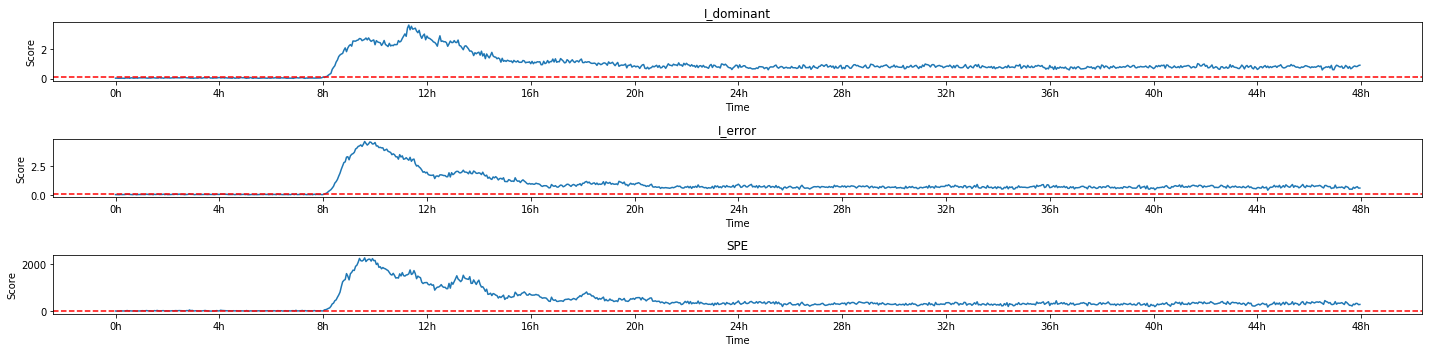

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(3, 1, 1)
plt.plot(I_d_test)
plt.title('I_dominant')
plt.xlabel('Time')
plt.ylabel('Score')
plt.axhline(y=I_d_thres, color='r', linestyle='--')
plt.xticks(np.arange(0, 980, 80), [str(x) + 'h' for x in np.arange(0, 49, 4)])

plt.subplot(3, 1, 2)
plt.plot(I_e_test)
plt.title('I_error')
plt.xlabel('Time')
plt.ylabel('Score')
plt.axhline(y=I_e_thres, color='r', linestyle='--')
plt.xticks(np.arange(0, 980, 80), [str(x) + 'h' for x in np.arange(0, 49, 4)])

plt.subplot(3, 1, 3)
plt.plot(SPE_test)
plt.title('SPE')
plt.xlabel('Time')
plt.ylabel('Score')
plt.axhline(y=SPE_thres, color='r', linestyle='--')
plt.xticks(np.arange(0, 980, 80), [str(x) + 'h' for x in np.arange(0, 49, 4)])

plt.tight_layout()
plt.show()

논문에서는 보통 (I_d > threshold) or (I_e > threshold) or (SPE > threshold)일 때 anomaly로 분류합니다.